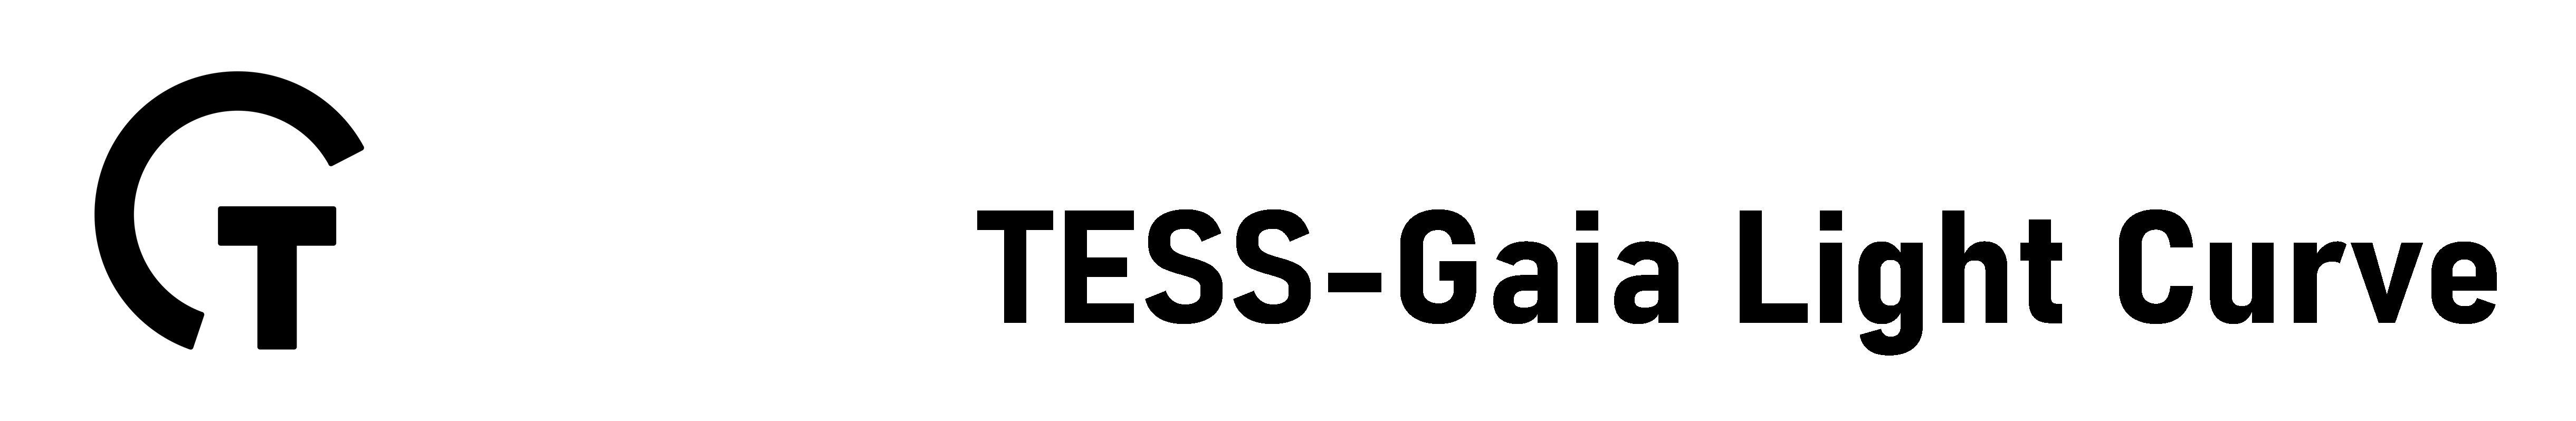

TESS-Gaia Light Curve (TGLC) is a dataset of TESS full-frame image light curves publicly available via the MAST portal. It is fitted with effective PSF and decontaminated with Gaia DR2 and achieved percent-level photometric precision down to 16th magnitude! It unlocks astrophysics to a vast number of dim stars below 12th magnitude. Here we introduce the basic data structure of our light curves and show simple analysis. 

# 1. Get the light curves

There are two ways to get the light curves: 
1. Download from the MAST portal 
2. Fit with the package `tglc`

too be continued ...

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# 2. Data structure

In [14]:
hdul_s007 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v1_llc.fits')
hdul_s007.info()

Filename: hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (5, 5, 1086)   float32   
  1  LIGHTCURVE    1 BinTableHDU     64   1086R x 13C   ['D', 'D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'E', 'J', 'I', 'I']   


The naming of tglc light curves follows the structure:
hlsp_tglc_tess_ffi_gaiaid-{Gaia DR2 ID}-s{sector}-cam{camera No.}-ccd{CCD No.}_tess_v1_llc.fits

Each light curve fits file has two HDUs: the Primary HDU is a 5\*5 pixels cut around the star (could be empty if you downloaded from MAST); the Second HDU contains the light curves. Below are the raw fluxes of TOI 519. 

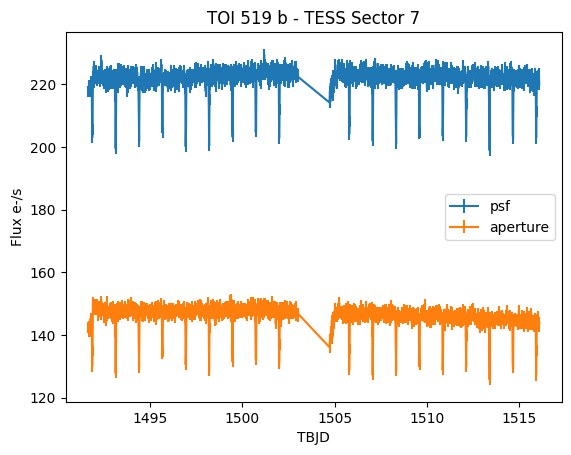

In [30]:
time_07 = hdul_s007[1].data['time']
psf_flux_07 = hdul_s007[1].data['psf_flux'] # raw psf flux
psf_flux_err_07 = hdul_s007[1].data['psf_flux_err'] # raw psf flux error
aper_flux_07 = hdul_s007[1].data['aperture_flux'] # raw aper flux
aper_flux_err_07 = hdul_s007[1].data['aperture_flux_err'] # raw aper flux error
plt.errorbar(time_07, psf_flux_07, psf_flux_err_07, marker = '', label = 'psf')
plt.errorbar(time_07, aper_flux_07, aper_flux_err_07, marker = '', label = 'aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

Note that the two light curves have different 

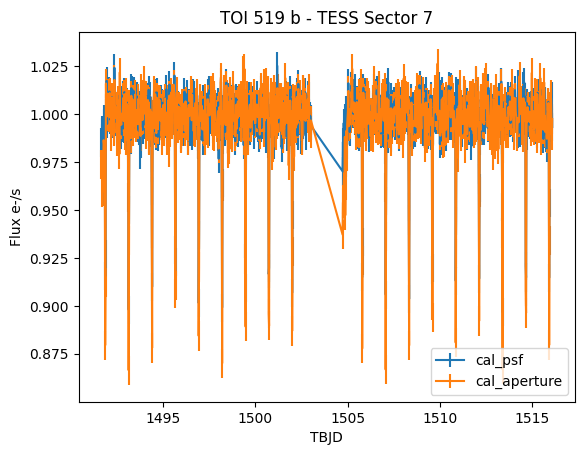

In [34]:
time_07 = hdul_s007[1].data['time']
cal_psf_flux_07 = hdul_s007[1].data['cal_psf_flux'] # raw psf flux
cal_psf_flux_err_07 = hdul_s007[1].data['cal_psf_flux_err'] # raw psf flux error
cal_aper_flux_07 = hdul_s007[1].data['cal_aper_flux'] # raw aper flux
cal_aper_flux_err_07 = hdul_s007[1].data['cal_aper_flux_err'] # raw aper flux error
plt.errorbar(time_07, cal_psf_flux_07, cal_psf_flux_err_07, marker = '', label = 'cal_psf')
plt.errorbar(time_07, cal_aper_flux_07, cal_aper_flux_err_07, marker = '', label = 'cal_aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()